## **Dataset**

In [1]:
from datasets import load_dataset

ds = load_dataset("wanhin/naruto-captions", split="train")

In [2]:
# get only 100 random samples
ds = ds.shuffle(seed=42).select(range(100))

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
text_encoder.eval()
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
ds["text"][0]

'a man with glasses and a shirt on'

In [5]:
# ds["image"][0]

In [6]:
# ds["image"][0].save("text_to_image.png", format="PNG")

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CFMDataset(Dataset):
    def __init__(self, dataset, text_encoder, tokenizer, device):
        self.dataset = dataset
        self.transform = transforms.Compose(
            [transforms.Resize((64, 64)), transforms.ToTensor()]
            
        )
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.device = device
        self.images = dataset["image"]
        self.captions = dataset["text"]
        self.cache = {}

    def get_embed(self, caption):
        inputs = self.tokenizer(
            caption,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        self.text_encoder.eval()
        with torch.no_grad():
            # Use mean pooling instead of just the first token
            text_features = self.text_encoder(**inputs).last_hidden_state
            # Mean pooling
            text_features = text_features.mean(dim=1)
        return text_features.squeeze(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        transformed_image = self.transform(self.images[idx])
        caption = self.captions[idx]
        caption_embedding = self.get_embed(caption)

        item = {
            "image": transformed_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

        self.cache[idx] = item
        return item

In [ ]:
train_ds = CFMDataset(ds, text_encoder, tokenizer, device)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)

## **Model**

In [18]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.embedding_layer = nn.Linear(embedding_dim, num_channels*4)
        self.fc = nn.Linear(num_channels*8, num_channels*4)

    def forward(self, t, x, text_embeddings=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(
            timestep_embedding(timesteps, self.model_channels)
        )

        if text_embeddings is not None:
            text_embedded = self.embedding_layer(text_embeddings)
            emb = torch.cat([emb, text_embedded], dim=1) # 128*2
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

## **Training**

In [10]:
model = UNetModelWithTextEmbedding(
    dim=(3, 64, 64), num_channels=64, num_res_blocks=1, embedding_dim=512, dropout=0.05, num_heads=4
).to(device)
optimizer = torch.optim.AdamW(model.parameters())

In [11]:
from tqdm import tqdm

n_epochs = 10000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

for epoch in tqdm(range(n_epochs)):
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        x1 = batch["image"].to(device)
        text_embeddings = batch["caption_embedding"].to(device)

        x0 = torch.randn_like(x1).to(device)

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0

        t = t.squeeze()

        vt = model(t, xt, text_embeddings=text_embeddings)

        loss = torch.mean(((vt - ut) ** 2))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  1%|          | 100/10000 [00:23<35:52,  4.60it/s]

Epoch [100/10000], Loss: 0.0771


  2%|▏         | 200/10000 [00:45<36:49,  4.43it/s]

Epoch [200/10000], Loss: 0.0566


  3%|▎         | 300/10000 [01:07<36:10,  4.47it/s]

Epoch [300/10000], Loss: 0.0691


  4%|▍         | 400/10000 [01:28<34:14,  4.67it/s]

Epoch [400/10000], Loss: 0.0493


  5%|▌         | 500/10000 [01:50<33:31,  4.72it/s]

Epoch [500/10000], Loss: 0.0465


  6%|▌         | 600/10000 [02:11<33:43,  4.65it/s]

Epoch [600/10000], Loss: 0.0399


  7%|▋         | 700/10000 [02:34<38:50,  3.99it/s]

Epoch [700/10000], Loss: 0.0355


  8%|▊         | 800/10000 [03:00<38:22,  4.00it/s]

Epoch [800/10000], Loss: 0.0330


  9%|▉         | 900/10000 [03:25<37:57,  3.99it/s]

Epoch [900/10000], Loss: 0.0294


 10%|█         | 1000/10000 [03:51<37:20,  4.02it/s]

Epoch [1000/10000], Loss: 0.0297


 11%|█         | 1100/10000 [04:15<36:55,  4.02it/s]

Epoch [1100/10000], Loss: 0.0218


 12%|█▏        | 1200/10000 [04:40<36:42,  3.99it/s]

Epoch [1200/10000], Loss: 0.0166


 13%|█▎        | 1300/10000 [05:05<36:15,  4.00it/s]

Epoch [1300/10000], Loss: 0.0236


 14%|█▍        | 1400/10000 [05:31<36:01,  3.98it/s]

Epoch [1400/10000], Loss: 0.0217


 15%|█▌        | 1500/10000 [05:54<36:58,  3.83it/s]

Epoch [1500/10000], Loss: 0.0139


 16%|█▌        | 1600/10000 [06:20<34:40,  4.04it/s]

Epoch [1600/10000], Loss: 0.0209


 17%|█▋        | 1700/10000 [06:45<34:21,  4.03it/s]

Epoch [1700/10000], Loss: 0.0203


 18%|█▊        | 1800/10000 [07:10<34:20,  3.98it/s]

Epoch [1800/10000], Loss: 0.0309


 19%|█▉        | 1900/10000 [07:37<33:52,  3.99it/s]

Epoch [1900/10000], Loss: 0.0135


 20%|██        | 2000/10000 [08:02<33:09,  4.02it/s]

Epoch [2000/10000], Loss: 0.0150


 21%|██        | 2100/10000 [08:26<28:20,  4.64it/s]

Epoch [2100/10000], Loss: 0.0142


 22%|██▏       | 2200/10000 [08:47<29:38,  4.39it/s]

Epoch [2200/10000], Loss: 0.0161


 23%|██▎       | 2300/10000 [09:09<27:41,  4.63it/s]

Epoch [2300/10000], Loss: 0.0131


 24%|██▍       | 2400/10000 [09:31<27:12,  4.66it/s]

Epoch [2400/10000], Loss: 0.0206


 25%|██▌       | 2500/10000 [09:52<26:39,  4.69it/s]

Epoch [2500/10000], Loss: 0.0140


 26%|██▌       | 2600/10000 [10:14<26:35,  4.64it/s]

Epoch [2600/10000], Loss: 0.0170


 27%|██▋       | 2700/10000 [10:36<30:28,  3.99it/s]

Epoch [2700/10000], Loss: 0.0090


 28%|██▊       | 2800/10000 [11:00<26:17,  4.56it/s]

Epoch [2800/10000], Loss: 0.0162


 29%|██▉       | 2900/10000 [11:22<27:01,  4.38it/s]

Epoch [2900/10000], Loss: 0.0253


 30%|███       | 3000/10000 [11:44<24:57,  4.68it/s]

Epoch [3000/10000], Loss: 0.0144


 31%|███       | 3100/10000 [12:06<25:22,  4.53it/s]

Epoch [3100/10000], Loss: 0.0169


 32%|███▏      | 3200/10000 [12:27<24:12,  4.68it/s]

Epoch [3200/10000], Loss: 0.0224


 33%|███▎      | 3300/10000 [12:50<26:21,  4.24it/s]

Epoch [3300/10000], Loss: 0.0231


 34%|███▍      | 3400/10000 [13:14<26:10,  4.20it/s]

Epoch [3400/10000], Loss: 0.0130


 35%|███▌      | 3500/10000 [13:37<24:05,  4.50it/s]

Epoch [3500/10000], Loss: 0.0149


 36%|███▌      | 3600/10000 [14:00<26:59,  3.95it/s]

Epoch [3600/10000], Loss: 0.0184


 37%|███▋      | 3700/10000 [14:24<22:53,  4.59it/s]

Epoch [3700/10000], Loss: 0.0174


 38%|███▊      | 3800/10000 [14:45<22:05,  4.68it/s]

Epoch [3800/10000], Loss: 0.0165


 39%|███▉      | 3900/10000 [15:07<22:04,  4.60it/s]

Epoch [3900/10000], Loss: 0.0208


 40%|████      | 4000/10000 [15:29<22:10,  4.51it/s]

Epoch [4000/10000], Loss: 0.0139


 41%|████      | 4100/10000 [15:51<21:27,  4.58it/s]

Epoch [4100/10000], Loss: 0.0121


 42%|████▏     | 4200/10000 [16:14<24:51,  3.89it/s]

Epoch [4200/10000], Loss: 0.0139


 43%|████▎     | 4300/10000 [16:40<24:22,  3.90it/s]

Epoch [4300/10000], Loss: 0.0091


 44%|████▍     | 4400/10000 [17:05<23:50,  3.91it/s]

Epoch [4400/10000], Loss: 0.0110


 45%|████▌     | 4501/10000 [17:29<19:01,  4.82it/s]

Epoch [4500/10000], Loss: 0.0175


 46%|████▌     | 4600/10000 [17:51<20:24,  4.41it/s]

Epoch [4600/10000], Loss: 0.0196


 47%|████▋     | 4700/10000 [18:12<18:24,  4.80it/s]

Epoch [4700/10000], Loss: 0.0091


 48%|████▊     | 4801/10000 [18:33<18:25,  4.70it/s]

Epoch [4800/10000], Loss: 0.0159


 49%|████▉     | 4900/10000 [18:54<17:46,  4.78it/s]

Epoch [4900/10000], Loss: 0.0188


 50%|█████     | 5000/10000 [19:15<17:48,  4.68it/s]

Epoch [5000/10000], Loss: 0.0073


 51%|█████     | 5100/10000 [19:37<18:14,  4.48it/s]

Epoch [5100/10000], Loss: 0.0354


 52%|█████▏    | 5201/10000 [19:59<16:50,  4.75it/s]

Epoch [5200/10000], Loss: 0.0072


 53%|█████▎    | 5300/10000 [20:20<17:03,  4.59it/s]

Epoch [5300/10000], Loss: 0.0116


 54%|█████▍    | 5400/10000 [20:41<16:22,  4.68it/s]

Epoch [5400/10000], Loss: 0.0137


 55%|█████▌    | 5500/10000 [21:02<15:40,  4.78it/s]

Epoch [5500/10000], Loss: 0.0157


 56%|█████▌    | 5600/10000 [21:23<15:29,  4.74it/s]

Epoch [5600/10000], Loss: 0.0187


 57%|█████▋    | 5700/10000 [21:44<15:00,  4.78it/s]

Epoch [5700/10000], Loss: 0.0104


 58%|█████▊    | 5801/10000 [22:06<14:43,  4.75it/s]

Epoch [5800/10000], Loss: 0.0128


 59%|█████▉    | 5901/10000 [22:27<14:25,  4.74it/s]

Epoch [5900/10000], Loss: 0.0117


 60%|██████    | 6000/10000 [22:50<15:55,  4.19it/s]

Epoch [6000/10000], Loss: 0.0095


 61%|██████    | 6100/10000 [23:13<13:49,  4.70it/s]

Epoch [6100/10000], Loss: 0.0104


 62%|██████▏   | 6200/10000 [23:34<13:07,  4.83it/s]

Epoch [6200/10000], Loss: 0.0126


 63%|██████▎   | 6300/10000 [23:55<13:06,  4.70it/s]

Epoch [6300/10000], Loss: 0.0106


 64%|██████▍   | 6400/10000 [24:16<12:41,  4.73it/s]

Epoch [6400/10000], Loss: 0.0090


 65%|██████▌   | 6500/10000 [24:39<14:23,  4.05it/s]

Epoch [6500/10000], Loss: 0.0133


 66%|██████▌   | 6600/10000 [25:04<13:53,  4.08it/s]

Epoch [6600/10000], Loss: 0.0125


 67%|██████▋   | 6700/10000 [25:28<13:23,  4.11it/s]

Epoch [6700/10000], Loss: 0.0107


 68%|██████▊   | 6800/10000 [25:54<13:44,  3.88it/s]

Epoch [6800/10000], Loss: 0.0126


 69%|██████▉   | 6901/10000 [26:16<10:46,  4.79it/s]

Epoch [6900/10000], Loss: 0.0131


 70%|███████   | 7001/10000 [26:37<10:26,  4.79it/s]

Epoch [7000/10000], Loss: 0.0050


 71%|███████   | 7100/10000 [26:58<10:05,  4.79it/s]

Epoch [7100/10000], Loss: 0.0281


 72%|███████▏  | 7200/10000 [27:19<09:44,  4.79it/s]

Epoch [7200/10000], Loss: 0.0157


 73%|███████▎  | 7301/10000 [27:40<09:19,  4.83it/s]

Epoch [7300/10000], Loss: 0.0102


 74%|███████▍  | 7401/10000 [28:00<09:02,  4.79it/s]

Epoch [7400/10000], Loss: 0.0100


 75%|███████▌  | 7500/10000 [28:21<08:42,  4.79it/s]

Epoch [7500/10000], Loss: 0.0152


 76%|███████▌  | 7601/10000 [28:42<08:20,  4.79it/s]

Epoch [7600/10000], Loss: 0.0048


 77%|███████▋  | 7701/10000 [29:04<07:58,  4.80it/s]

Epoch [7700/10000], Loss: 0.0265


 78%|███████▊  | 7800/10000 [29:28<08:49,  4.15it/s]

Epoch [7800/10000], Loss: 0.0162


 79%|███████▉  | 7900/10000 [29:52<08:25,  4.16it/s]

Epoch [7900/10000], Loss: 0.0070


 80%|████████  | 8000/10000 [30:14<07:19,  4.55it/s]

Epoch [8000/10000], Loss: 0.0168


 81%|████████  | 8100/10000 [30:36<06:35,  4.81it/s]

Epoch [8100/10000], Loss: 0.0086


 82%|████████▏ | 8201/10000 [30:57<06:23,  4.69it/s]

Epoch [8200/10000], Loss: 0.0134


 83%|████████▎ | 8300/10000 [31:18<05:55,  4.78it/s]

Epoch [8300/10000], Loss: 0.0075


 84%|████████▍ | 8400/10000 [31:40<05:57,  4.48it/s]

Epoch [8400/10000], Loss: 0.0156


 85%|████████▌ | 8501/10000 [32:01<05:17,  4.71it/s]

Epoch [8500/10000], Loss: 0.0099


 86%|████████▌ | 8600/10000 [32:23<05:06,  4.57it/s]

Epoch [8600/10000], Loss: 0.0192


 87%|████████▋ | 8700/10000 [32:45<04:37,  4.68it/s]

Epoch [8700/10000], Loss: 0.0081


 88%|████████▊ | 8800/10000 [33:06<04:09,  4.82it/s]

Epoch [8800/10000], Loss: 0.0126


 89%|████████▉ | 8900/10000 [33:27<03:53,  4.71it/s]

Epoch [8900/10000], Loss: 0.0170


 90%|█████████ | 9001/10000 [33:49<03:26,  4.83it/s]

Epoch [9000/10000], Loss: 0.0109


 91%|█████████ | 9100/10000 [34:09<03:07,  4.80it/s]

Epoch [9100/10000], Loss: 0.0228


 92%|█████████▏| 9200/10000 [34:31<03:13,  4.12it/s]

Epoch [9200/10000], Loss: 0.0098


 93%|█████████▎| 9300/10000 [34:56<02:51,  4.08it/s]

Epoch [9300/10000], Loss: 0.0081


 94%|█████████▍| 9400/10000 [35:20<02:23,  4.17it/s]

Epoch [9400/10000], Loss: 0.0264


 95%|█████████▌| 9500/10000 [35:45<01:53,  4.40it/s]

Epoch [9500/10000], Loss: 0.0091


 96%|█████████▌| 9600/10000 [36:07<01:30,  4.43it/s]

Epoch [9600/10000], Loss: 0.0060


 97%|█████████▋| 9701/10000 [36:28<01:02,  4.78it/s]

Epoch [9700/10000], Loss: 0.0289


 98%|█████████▊| 9801/10000 [36:50<00:41,  4.77it/s]

Epoch [9800/10000], Loss: 0.0136


 99%|█████████▉| 9901/10000 [37:11<00:20,  4.78it/s]

Epoch [9900/10000], Loss: 0.0069


100%|██████████| 10000/10000 [37:32<00:00,  4.44it/s]

Epoch [10000/10000], Loss: 0.0063


In [11]:

torch.cuda.empty_cache()

## **Inference**

# Batch of sample test

In [64]:
model.eval()
def euler_method(model, text_embedding, t_steps, dt, noise):
    y = noise
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            dy = model(
                t.to(device), y,
                text_embeddings=text_embedding
            )
            y = y + dy * dt
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
image = sample["image"].to(device)
text_embeddings = sample["caption_embedding"].to(device)
noise = torch.randn_like(image, device=device)

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embeddings, t_steps, dt, noise)

# Single desired sample test

In [61]:
input_prompt = "a man with glasses"
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
noise = torch.randn((1, 3, 64, 64), device=device)
results = euler_method(model, text_embedding, t_steps, dt, noise)

In [59]:
torch.cuda.empty_cache()

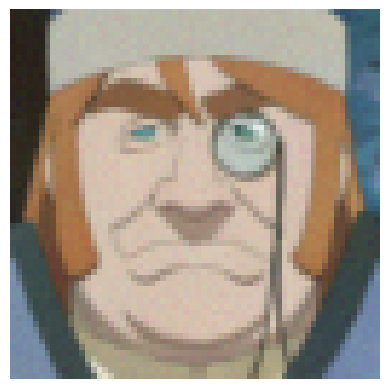

In [62]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

grid = make_grid(
    results[-1, -5:], padding=0, nrow=10
)
def tensor_to_image(tensor):
    return F.to_pil_image(tensor.clamp(0, 1))

img = tensor_to_image(grid)
plt.axis("off")
plt.imshow(img)
plt.show()

In [62]:
results.shape

torch.Size([50, 20, 3, 64, 64])

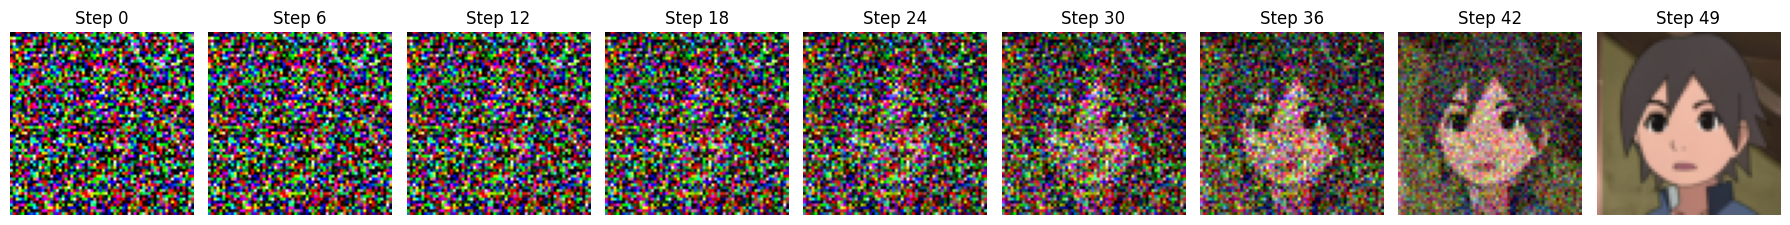

✅ Saved GIF to 'sample_2.gif'


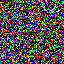

In [27]:
from IPython.display import display, Image as IPyImage

def show_and_save_sampling_progress(results, sample_idx=0, num_steps=9, save_path="sampling.gif", duration=300):
    """
    Hiển thị quá trình sampling (dạng ảnh) và đồng thời lưu thành file GIF.

    Args:
        traj (Tensor): Tensor 5D (T, B, C, H, W)
        sample_idx (int): Index của sample trong batch
        num_steps (int): Số bước sampling để hiển thị và lưu gif
        save_path (str): Đường dẫn file gif muốn lưu
        duration (int): Thời gian mỗi frame (milliseconds)
    """
    T = results.shape[0]
    assert num_steps <= T, "Số bước cần hiển thị phải nhỏ hơn hoặc bằng tổng số bước."

    # Lấy các bước cách đều từ 0 đến T-1
    indices = torch.linspace(0, T - 1, num_steps).long()

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 6))
    frames = []

    for i, idx in enumerate(indices):
        img_tensor = results[idx, sample_idx]  # (C, H, W)
        pil_img = tensor_to_image(img_tensor.cpu())
        frames.append(pil_img)

        # Hiển thị bằng matplotlib
        axes[i].imshow(pil_img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {idx.item()}")

    plt.tight_layout()
    plt.show()

    # Save GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to '{save_path}'")

    display(IPyImage(filename=save_path))

sample_idx = 2
show_and_save_sampling_progress(results, sample_idx=sample_idx, num_steps=9, save_path=f"sample_{sample_idx}.gif")